# Step 1 - Load Libraries

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report, f1_score

# Step 2 - Read in the Data

In [3]:
# Read dataset into notebook
df = pd.read_csv('Data/CandidateSummaryAction1.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814 entries, 0 to 1813
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   can_id                 1814 non-null   object 
 1   can_nam                1814 non-null   object 
 2   can_off                1814 non-null   object 
 3   can_off_sta            1814 non-null   object 
 4   can_off_dis            1812 non-null   float64
 5   can_par_aff            1813 non-null   object 
 6   can_inc_cha_ope_sea    1812 non-null   object 
 7   can_str1               1789 non-null   object 
 8   can_str2               122 non-null    object 
 9   can_cit                1813 non-null   object 
 10  can_sta                1806 non-null   object 
 11  can_zip                1789 non-null   float64
 12  ind_ite_con            1570 non-null   object 
 13  ind_uni_con            1538 non-null   object 
 14  ind_con                1616 non-null   object 
 15  par_

# Step 3 - Data Cleaning

In [4]:
# Remove parentheses
df = df.replace(to_replace='\(', value="", regex=True)
df = df.replace(to_replace='\)', value="", regex=True)

In [5]:
# Remove dollar signs from columns 12-46
df[df.columns[12:47]] = df[df.columns[12:47]].replace('[\$,]', '', regex=True)

In [6]:
# Replace empty spaces in columns 12-46 with nan
df[df.columns[12:47]] = df[df.columns[12:47]].replace(r'^\s*$', np.nan, regex=True)

In [7]:
# Change values in columns 12-46 to floats
df[df.columns[12:47]] = df[df.columns[12:47]].astype(float)

In [8]:
# replace Y in 'winner' column with 1
df['winner'] = np.where(df['winner']=='Y', 1, df['winner'])

In [9]:
# replace NaN in 'winner' column with 0
df['winner'] = df['winner'].fillna(0)

In [10]:
# Drop 'P' from 'can_off column'
df = df[df["can_off"] != 'P']
df.reset_index(drop=True, inplace=True)

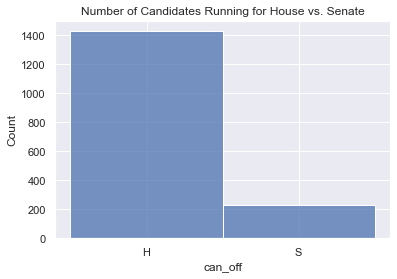

In [11]:
sns.set_theme(style="darkgrid")
sns.histplot(df, x='can_off')
plt.title('Number of Candidates Running for House vs. Senate');

In [12]:
df['can_off'].value_counts()

H    1429
S     227
Name: can_off, dtype: int64

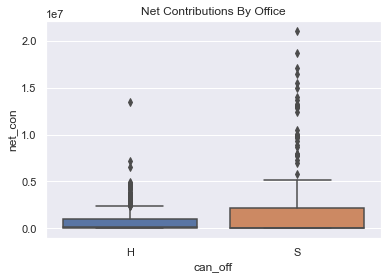

In [13]:
sns.set(style='darkgrid')
sns.boxplot(x=df['can_off'],y=df['net_con'])
plt.title('Net Contributions By Office');

In [14]:
# Drop features
df = df.drop(['can_id', 'can_str1', 'can_str2', 'can_cit', 'can_sta', 'off_to_fun',
              'off_to_leg_acc', 'exe_leg_acc_dis', 'fun_dis', 'cov_sta_dat', 'cov_end_dat',
              'votes', 'can_nam', 'can_off_sta'], axis=1)

In [15]:
# replace parties that are not DEM REP or IND in 'can_par_aff' column with 'OTHER'
df['can_par_aff'] = np.where((df['can_par_aff'] != ('REP')) & (df['can_par_aff'] != ('DEM')) & (df['can_par_aff'] != ('IND')),
                             'OTHER', df['can_par_aff'])

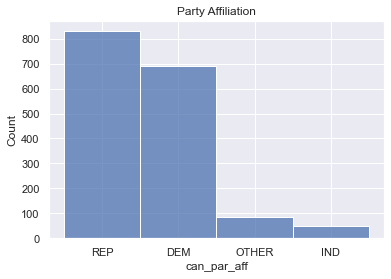

In [16]:
sns.set_theme(style="darkgrid")
sns.histplot(df, x='can_par_aff')
plt.title('Party Affiliation');

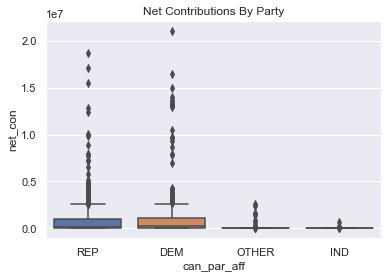

In [17]:
sns.set(style='darkgrid')
sns.boxplot(x=df['can_par_aff'],y=df['net_con'])
plt.title('Net Contributions By Party');

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   can_off                1656 non-null   object 
 1   can_off_dis            1654 non-null   float64
 2   can_par_aff            1656 non-null   object 
 3   can_inc_cha_ope_sea    1654 non-null   object 
 4   can_zip                1635 non-null   float64
 5   ind_ite_con            1509 non-null   float64
 6   ind_uni_con            1479 non-null   float64
 7   ind_con                1545 non-null   float64
 8   par_com_con            378 non-null    float64
 9   oth_com_con            987 non-null    float64
 10  can_con                616 non-null    float64
 11  tot_con                1595 non-null   float64
 12  tra_fro_oth_aut_com    251 non-null    float64
 13  can_loa                603 non-null    float64
 14  oth_loa                59 non-null     float64
 15  tot_

# Step 3 - EDA

In [19]:
# Correlation
df.corr()

,can_off_dis,can_zip,ind_ite_con,ind_uni_con,ind_con,par_com_con,oth_com_con,can_con,tot_con,tra_fro_oth_aut_com,can_loa,oth_loa,tot_loa,off_to_ope_exp,oth_rec,tot_rec,ope_exp,tra_to_oth_aut_com,can_loa_rep,oth_loa_rep,tot_loa_rep,ind_ref,par_com_ref,oth_com_ref,tot_con_ref,oth_dis,tot_dis,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,deb_owe_to_com,winner
can_off_dis,1.00,0.06,-0.10,-0.09,-0.10,-0.12,-0.05,0.01,-0.08,-0.13,-0.03,-0.13,-0.04,-0.03,-0.02,-0.09,-0.09,-0.12,-0.06,0.13,-0.05,-0.13,-0.25,-0.13,-0.13,-0.02,-0.09,-0.07,-0.04,-0.08,-0.09,-0.04,-0.00,0.04
can_zip,0.06,1.00,0.08,0.00,0.06,0.05,0.30,-0.01,0.13,0.07,0.00,-0.04,-0.00,0.08,0.02,0.13,0.10,0.12,0.05,0.20,0.05,-0.04,-0.14,0.03,-0.03,0.12,0.12,0.08,0.16,0.13,0.09,-0.02,-0.04,0.29
ind_ite_con,-0.10,0.08,1.00,0.71,0.98,0.40,0.60,0.04,0.98,0.40,0.11,0.24,0.11,0.30,0.32,0.95,0.92,-0.04,0.08,0.43,0.09,0.50,0.45,0.28,0.52,0.27,0.93,0.46,0.59,0.97,0.90,0.06,-0.11,0.29
ind_uni_con,-0.09,0.00,0.71,1.00,0.83,0.31,0.25,-0.02,0.75,0.20,0.03,0.51,0.04,0.21,0.08,0.71,0.71,-0.02,0.09,-0.03,0.08,0.37,0.43,0.10,0.37,0.02,0.70,0.19,0.25,0.75,0.74,0.05,-0.12,0.11
ind_con,-0.10,0.06,0.98,0.83,1.00,0.39,0.54,-0.00,0.96,0.37,0.09,0.32,0.10,0.30,0.28,0.94,0.91,-0.04,0.09,0.39,0.09,0.50,0.45,0.25,0.51,0.22,0.91,0.44,0.53,0.96,0.90,0.06,-0.11,0.27
par_com_con,-0.12,0.05,0.40,0.31,0.39,1.00,0.34,-0.02,0.41,0.60,0.08,-0.24,0.08,0.41,0.12,0.41,0.39,0.29,-0.06,-0.70,-0.06,0.21,0.78,0.25,0.23,0.02,0.39,0.28,0.42,0.41,0.38,0.15,-0.19,0.05
oth_com_con,-0.05,0.30,0.60,0.25,0.54,0.34,1.00,-0.02,0.71,0.27,0.01,-0.05,0.01,0.35,0.23,0.68,0.62,0.08,0.07,-0.06,0.06,0.14,0.30,0.23,0.17,0.39,0.65,0.42,0.63,0.71,0.58,-0.01,0.11,0.60
can_con,0.01,-0.01,0.04,-0.02,-0.00,-0.02,-0.02,1.00,0.46,-0.09,0.31,0.05,0.30,0.00,-0.02,0.43,0.47,-0.06,0.23,0.99,0.30,-0.01,0.22,-0.09,-0.01,-0.02,0.47,0.05,0.00,0.46,0.47,0.27,0.95,0.03
tot_con,-0.08,0.13,0.98,0.75,0.96,0.41,0.71,0.46,1.00,0.38,0.16,0.27,0.15,0.34,0.28,0.97,0.94,-0.00,0.09,0.41,0.09,0.46,0.45,0.27,0.48,0.28,0.95,0.47,0.60,1.00,0.92,0.08,-0.13,0.39
tra_fro_oth_aut_com,-0.13,0.07,0.40,0.20,0.37,0.60,0.27,-0.09,0.38,1.00,0.11,nan,0.11,0.08,0.02,0.56,0.39,0.14,0.25,nan,0.25,0.20,0.09,0.03,0.19,0.66,0.48,0.17,0.49,0.38,0.38,-0.01,-1.00,0.02


In [20]:
# Correlation to with 'winner' column  
correlations = df.corr()['winner'].map(abs).sort_values(ascending=False)
correlations

winner                  1.00
oth_com_con             0.60
cas_on_han_clo_of_per   0.44
net_con                 0.40
tot_con                 0.39
tot_rec                 0.37
par_com_ref             0.35
tot_dis                 0.33
ope_exp                 0.29
can_zip                 0.29
ind_ite_con             0.29
net_ope_exp             0.28
ind_con                 0.27
oth_loa_rep             0.26
oth_dis                 0.25
tra_to_oth_aut_com      0.24
cas_on_han_beg_of_per   0.21
deb_owe_to_com          0.20
off_to_ope_exp          0.14
oth_com_ref             0.12
tot_loa_rep             0.12
oth_rec                 0.12
can_loa_rep             0.11
ind_uni_con             0.11
ind_ref                 0.10
oth_loa                 0.10
tot_con_ref             0.10
tot_loa                 0.09
can_loa                 0.09
par_com_con             0.05
deb_owe_by_com          0.05
can_off_dis             0.04
can_con                 0.03
tra_fro_oth_aut_com     0.02
Name: winner, 

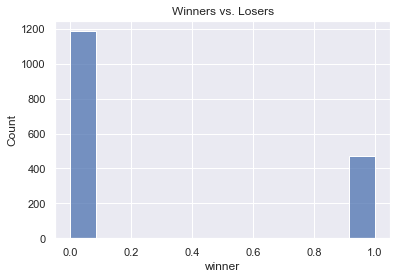

In [21]:
sns.histplot(df, x="winner")
plt.title('Winners vs. Losers');

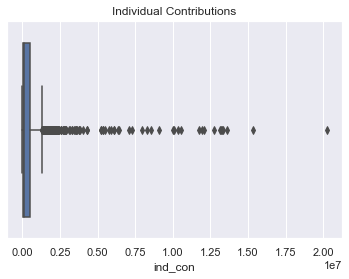

In [22]:
sns.set_theme(style='darkgrid')
ax = sns.boxplot(x=df['ind_con'])
plt.title('Individual Contributions');

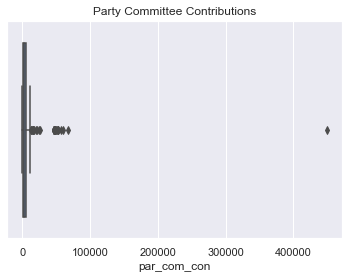

In [23]:
sns.set_theme(style='darkgrid')
ax = sns.boxplot(x=df['par_com_con'])
plt.title('Party Committee Contributions');

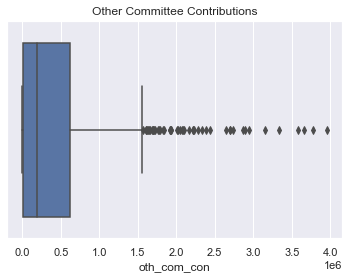

In [24]:
sns.set_theme(style='darkgrid')
ax = sns.boxplot(x=df['oth_com_con'])
plt.title('Other Committee Contributions');

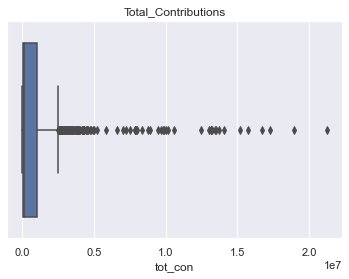

In [25]:
sns.set_theme(style='darkgrid')
ax = sns.boxplot(x=df['tot_con'])
plt.title('Total_Contributions');

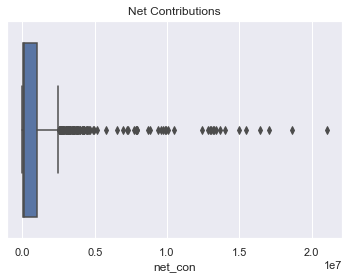

In [26]:
sns.set_theme(style='darkgrid')
ax = sns.boxplot(x=df['net_con'])
plt.title('Net Contributions');

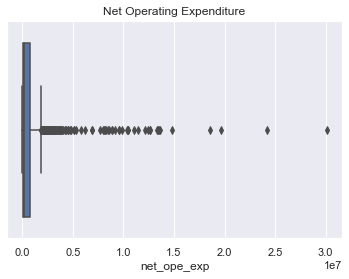

In [27]:
sns.set_theme(style='darkgrid')
ax = sns.boxplot(x=df['net_ope_exp'])
plt.title('Net Operating Expenditure');

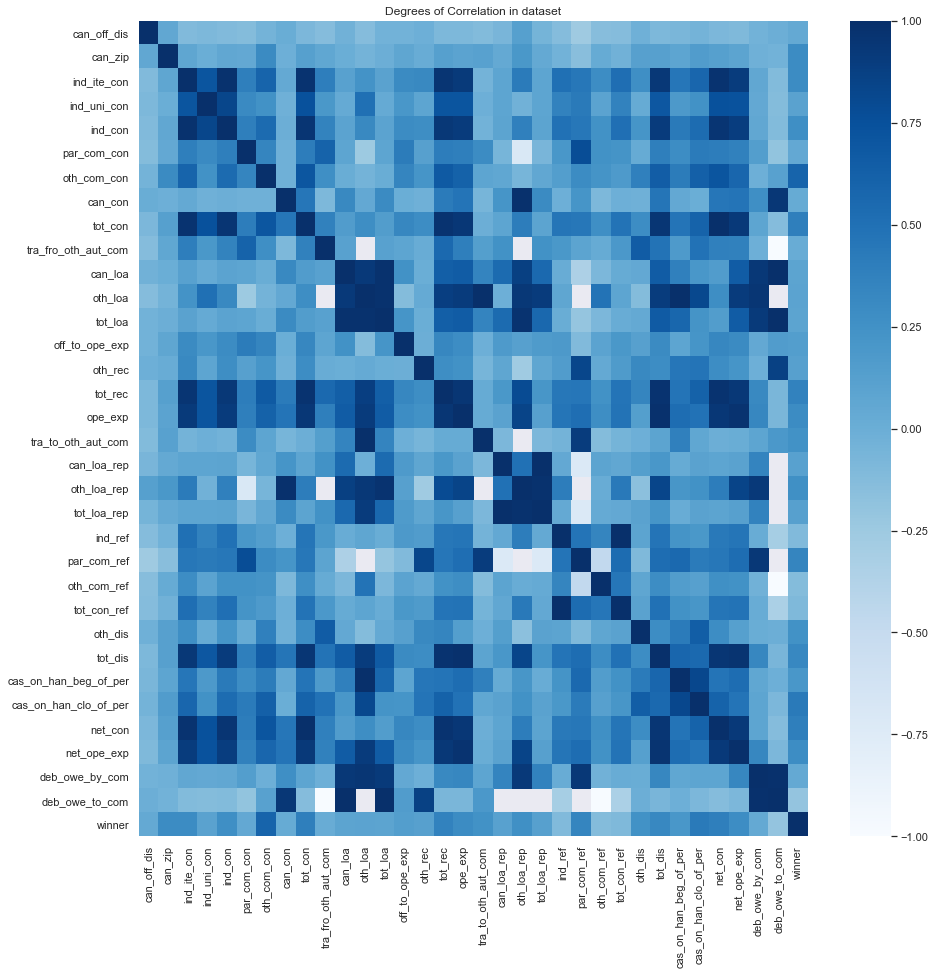

In [28]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=False, cmap='Blues', center= 0, ax=ax)
plt.title('Degrees of Correlation in dataset');

# Step 4 - Modelling

**Run Base Model**

In [29]:
# Run dummy classifier to get baseline prediction
from sklearn.dummy import DummyClassifier
X = df.drop('winner', axis=1)
y = df['winner']
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X)
dummy_clf.score(X, y)

0.716183574879227

**Data Preprocessing**

In [30]:
# Create matrix of features
X = df.drop('winner', axis = 1) # grabs everything else but 'winner'

# Create target variable
y = df['winner'] # y is the column we're trying to predict

# Create a list of the features to be used in the model
feature_cols = X.columns

In [31]:
# Use x and y variables to split the training data into train and test set then scale that data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1242 entries, 1149 to 1061
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   can_off                1242 non-null   object 
 1   can_off_dis            1240 non-null   float64
 2   can_par_aff            1242 non-null   object 
 3   can_inc_cha_ope_sea    1240 non-null   object 
 4   can_zip                1229 non-null   float64
 5   ind_ite_con            1134 non-null   float64
 6   ind_uni_con            1113 non-null   float64
 7   ind_con                1160 non-null   float64
 8   par_com_con            280 non-null    float64
 9   oth_com_con            742 non-null    float64
 10  can_con                472 non-null    float64
 11  tot_con                1200 non-null   float64
 12  tra_fro_oth_aut_com    189 non-null    float64
 13  can_loa                448 non-null    float64
 14  oth_loa                43 non-null     float64
 15  t

In [33]:
# Define categorical columns
cat_cols = [col for col in X_train.columns if X_train[col].dtypes not in ['float64', 'int64']]
cat_cols

['can_off', 'can_par_aff', 'can_inc_cha_ope_sea']

In [34]:
# Define numerical colummns
num_cols = [col for col in X_train.columns if col not in cat_cols]
num_cols

['can_off_dis',
 'can_zip',
 'ind_ite_con',
 'ind_uni_con',
 'ind_con',
 'par_com_con',
 'oth_com_con',
 'can_con',
 'tot_con',
 'tra_fro_oth_aut_com',
 'can_loa',
 'oth_loa',
 'tot_loa',
 'off_to_ope_exp',
 'oth_rec',
 'tot_rec',
 'ope_exp',
 'tra_to_oth_aut_com',
 'can_loa_rep',
 'oth_loa_rep',
 'tot_loa_rep',
 'ind_ref',
 'par_com_ref',
 'oth_com_ref',
 'tot_con_ref',
 'oth_dis',
 'tot_dis',
 'cas_on_han_beg_of_per',
 'cas_on_han_clo_of_per',
 'net_con',
 'net_ope_exp',
 'deb_owe_by_com',
 'deb_owe_to_com']

In [35]:
# Create pipelines for categorical and numerical columns
cat_pipe = Pipeline(steps=[
    ('simp', SimpleImputer(strategy = 'constant', fill_value='N/A')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline(steps=[
    ('simp', SimpleImputer(strategy = 'constant', fill_value=0)),
    ('scaler', StandardScaler())
])

In [36]:
# Fit and transform training data in numerical columns
num_pipe.fit_transform(X_train[num_cols])

array([[ 4.25705408, -0.2948057 , -0.37655433, ..., -0.36932788,
        -0.23045181, -0.04042312],
       [-0.06095744, -0.29516778, -0.37106403, ..., -0.24928028,
         2.59545613, -0.04042312],
       [-0.54073649, -0.29508446, -0.16771129, ..., -0.06048513,
        -0.10616699, -0.04042312],
       ...,
       [ 4.06514245, -0.2948059 , -0.37657564, ..., -0.36176967,
        -0.11238575, -0.04042312],
       [-0.73264812, -0.29526124,  1.60967676, ...,  0.97763177,
        -0.23045181, -0.04042312],
       [-0.44478068, -0.29511793, -0.37636251, ..., -0.36609941,
        -0.19881568, -0.04042312]])

In [37]:
# Run ColumnTransformer on a list of tuples containing the names of our pipelines, the actual pipelines and the target columns
preprocess = ColumnTransformer(transformers=[
    ('cat_cleaning', cat_pipe, cat_cols),
    ('num_cleaning', num_pipe, num_cols)
])

**Logistic Regression Pipeline**

In [39]:
# Create pipeline for logistic regression model
lr_pipe_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('lr', LogisticRegression())
])

In [40]:
# Define gridsearch parameters
lr_param_grid = {
    'lr__max_iter': [100, 200, 300],
    'lr__solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
}

In [41]:
# Combine logistic regression pipeline with gridsearch
lr_grid = GridSearchCV(lr_pipe_model, lr_param_grid, scoring='f1')

In [42]:
# Fit pipeline with gridsearch 
lr_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_cleaning',
                                                                         Pipeline(steps=[('simp',
                                                                                          SimpleImputer(fill_value='N/A',
                                                                                                        strategy='constant')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['can_off',
                                                                          'ca

In [43]:
# Display best parameters
lr_grid.best_params_

{'lr__max_iter': 100, 'lr__solver': 'sag'}

In [44]:
# Create function to evaluate model, display confusion matrix and plot ROC curve
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    
    print(classification_report(y, y_pred))
    
    fig, axes=plt.subplots(ncols=2, figsize=(10,4))
    
    plot_confusion_matrix(model, X, y, cmap='Blues', normalize='true', ax=axes[0])
    
    plot_roc_curve(model, X, y, ax=axes[1])
    
    axes[0].set_title('Confusion Matrix')
    axes[1].set_title('ROC Curve')

    # Setting threshold line
    axes[1].plot([0,1],[0,1], ls=':')
    plt.tight_layout()

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       888
           1       0.96      0.89      0.92       354

    accuracy                           0.96      1242
   macro avg       0.96      0.94      0.95      1242
weighted avg       0.96      0.96      0.96      1242



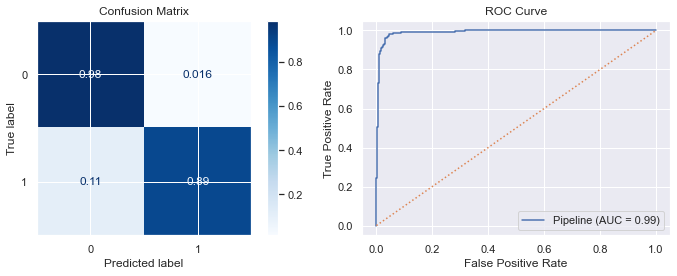

In [45]:
# Run function on training data
evaluate_model(lr_grid.best_estimator_, X_train, y_train)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       298
           1       0.89      0.91      0.90       116

    accuracy                           0.94       414
   macro avg       0.93      0.94      0.93       414
weighted avg       0.94      0.94      0.94       414



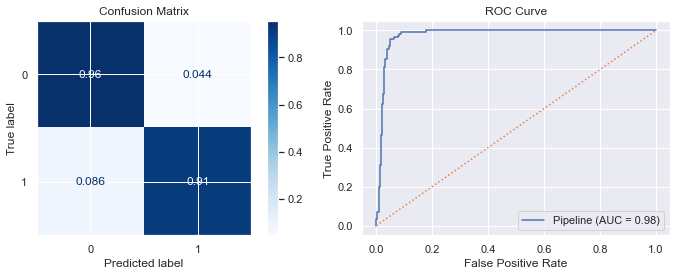

In [46]:
# Run function on test data
evaluate_model(lr_grid.best_estimator_, X_test, y_test)

**RandomForest Pipeline**

In [47]:
# Create pipeline for RandomForest
rf_pipe_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', RandomForestClassifier())
])

In [48]:
# Define gridsearch parameters
rf_param_grid = {
    'rf__n_estimators': [50, 150, 250],
    'rf__max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'rf__min_samples_split': [2, 4, 6]
}

In [49]:
# Combine logistic regression pipeline with gridsearch
rf_grid = GridSearchCV(rf_pipe_model, rf_param_grid, scoring='f1')

In [50]:
# Fit pipeline with gridsearch 
rf_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_cleaning',
                                                                         Pipeline(steps=[('simp',
                                                                                          SimpleImputer(fill_value='N/A',
                                                                                                        strategy='constant')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['can_off',
                                                                          'ca

In [51]:
# Display best parameters
rf_grid.best_params_

{'rf__max_features': 'sqrt',
 'rf__min_samples_split': 6,
 'rf__n_estimators': 150}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       888
           1       1.00      0.99      1.00       354

    accuracy                           1.00      1242
   macro avg       1.00      1.00      1.00      1242
weighted avg       1.00      1.00      1.00      1242



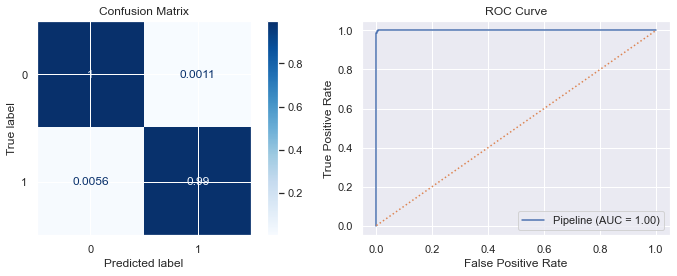

In [52]:
# Run function on training data
evaluate_model(rf_grid.best_estimator_, X_train, y_train)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       298
           1       0.90      0.97      0.93       116

    accuracy                           0.96       414
   macro avg       0.94      0.96      0.95       414
weighted avg       0.96      0.96      0.96       414



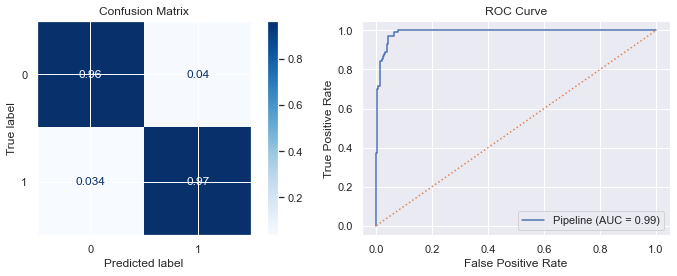

In [53]:
#Run Function on test data
evaluate_model(rf_grid.best_estimator_, X_test, y_test)

In [54]:
#feature name extraction
preprocess.named_transformers_['cat_cleaning'].named_steps['ohe'].get_feature_names()

array(['x0_H', 'x0_S', 'x1_DEM', 'x1_IND', 'x1_OTHER', 'x1_REP',
       'x2_CHALLENGER', 'x2_INCUMBENT', 'x2_N/A', 'x2_OPEN'], dtype=object)

In [55]:
# Show categorical feature names
cat_feat_names = preprocess.named_transformers_['cat_cleaning'].named_steps['ohe'].get_feature_names(cat_cols).tolist()
cat_feat_names

['can_off_H',
 'can_off_S',
 'can_par_aff_DEM',
 'can_par_aff_IND',
 'can_par_aff_OTHER',
 'can_par_aff_REP',
 'can_inc_cha_ope_sea_CHALLENGER',
 'can_inc_cha_ope_sea_INCUMBENT',
 'can_inc_cha_ope_sea_N/A',
 'can_inc_cha_ope_sea_OPEN']

In [56]:
# Create function to extract categorical and numerical feature names
def feat_importance(model, cat_cols, num_cols, label=None):
    #Get categorical and numerical names from preprocessing
    cat_feat_names = preprocess.named_transformers_['cat_cleaning'].named_steps['ohe'].get_feature_names(cat_cols).tolist()
    feat_cols = cat_feat_names + num_cols
    feat_importance=pd.Series(model.named_steps[label].feature_importances_, index=feat_cols)
    return feat_importance

In [57]:
# Show feature importance
feat_importance(rf_grid.best_estimator_, cat_cols, num_cols, label='rf')

can_off_H                        0.00
can_off_S                        0.00
can_par_aff_DEM                  0.00
can_par_aff_IND                  0.00
can_par_aff_OTHER                0.00
can_par_aff_REP                  0.00
can_inc_cha_ope_sea_CHALLENGER   0.02
can_inc_cha_ope_sea_INCUMBENT    0.16
can_inc_cha_ope_sea_N/A          0.00
can_inc_cha_ope_sea_OPEN         0.00
can_off_dis                      0.00
can_zip                          0.00
ind_ite_con                      0.01
ind_uni_con                      0.01
ind_con                          0.02
par_com_con                      0.00
oth_com_con                      0.14
can_con                          0.01
tot_con                          0.07
tra_fro_oth_aut_com              0.00
can_loa                          0.00
oth_loa                          0.00
tot_loa                          0.01
off_to_ope_exp                   0.01
oth_rec                          0.00
tot_rec                          0.04
ope_exp     

In [58]:
# Create a variable for feature importance
feat_importances = feat_importance(rf_grid.best_estimator_, cat_cols, num_cols, label='rf')

In [59]:
# Sort feature importance by weight
important_feats = feat_importances.sort_values(ascending=False).head(10)
important_feats

can_inc_cha_ope_sea_INCUMBENT   0.16
oth_com_con                     0.14
cas_on_han_clo_of_per           0.12
cas_on_han_beg_of_per           0.10
net_con                         0.08
tot_con                         0.07
ope_exp                         0.05
tot_dis                         0.04
tot_rec                         0.04
net_ope_exp                     0.03
dtype: float64

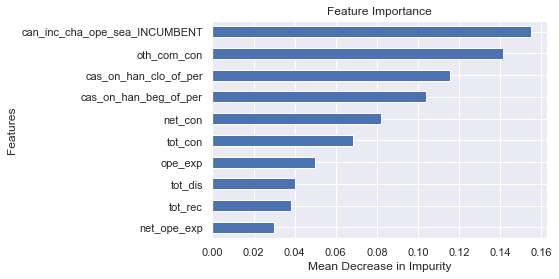

In [69]:
# Plot top 10 most important features
important_feats.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Mean Decrease in Impurity')
plt.ylabel('Features');

**XGBoost**

In [61]:
# Create pipeline for XGBoost
xg_pipe_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('xg', XGBClassifier())
])

In [62]:
# Define gridsearch parameters
xg_param_grid = {
    'xg__min_child_weight': [1, 5, 10],
    'xg__gamma': [0.5, 1, 1.5, 2, 5],
    'xg__subsample': [0.6, 0.8, 1.0],
    'xg__colsample_bytree': [0.6, 0.8, 1.0],
    'xg__max_depth': [3, 4, 5]
}

In [63]:
# Combine logistic regression pipeline with gridsearch
xg_grid = GridSearchCV(xg_pipe_model, xg_param_grid, scoring='f1')

In [64]:
# Fit pipeline with gridsearch 
xg_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_cleaning',
                                                                         Pipeline(steps=[('simp',
                                                                                          SimpleImputer(fill_value='N/A',
                                                                                                        strategy='constant')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['can_off',
                                                                          'ca

In [65]:
# Display best parameters
xg_grid.best_params_

{'xg__colsample_bytree': 1.0,
 'xg__gamma': 1,
 'xg__max_depth': 5,
 'xg__min_child_weight': 1,
 'xg__subsample': 0.8}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       888
           1       1.00      1.00      1.00       354

    accuracy                           1.00      1242
   macro avg       1.00      1.00      1.00      1242
weighted avg       1.00      1.00      1.00      1242



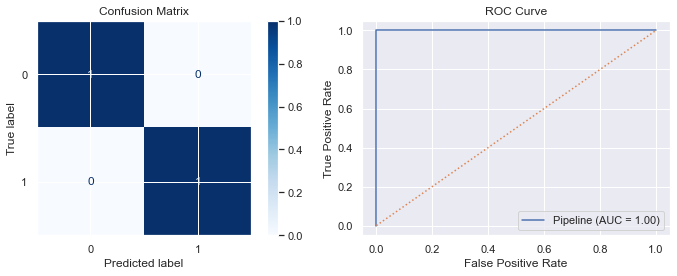

In [66]:
# Run function on training data
evaluate_model(xg_grid.best_estimator_, X_train, y_train)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       298
           1       0.89      0.97      0.93       116

    accuracy                           0.96       414
   macro avg       0.94      0.96      0.95       414
weighted avg       0.96      0.96      0.96       414



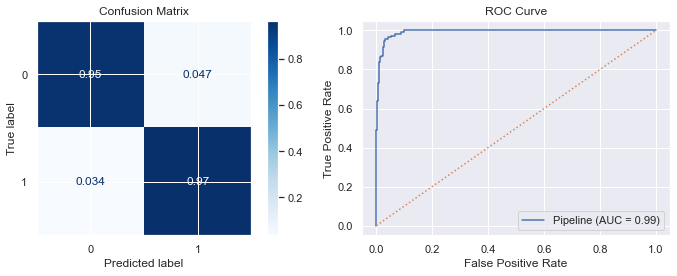

In [67]:
#Run Function on test data
evaluate_model(xg_grid.best_estimator_, X_test, y_test)

**Fin**